<a href="https://colab.research.google.com/github/UCI-CHRS/GEE-Training-2025/blob/main/notebooks/Tutorial02_SurfaceWater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>  


# **Surface Water Change Over Time**  
### **PEER2PEER GEE Training**  
**Developed by:** Annika Hjelmstad<sup>1</sup>, Debora Yumi de Oliveira<sup>1,2</sup>, Muhammad Umar Akbar<sup>3</sup>, Kasra Khodkar<sup>3</sup>

**Affiliation:**

<sup>1</sup>Department of Civil and Environmental Engineering, University of California at Irvine, Irvine, USA  
<sup>2</sup>Mackenzie Presbyterian University, São Paulo, Brazil  
<sup>3</sup>Department of Biosystems and Agricultural Engineering, Oklahoma State University, Stillwater, USA  

</center>

---

## **Introduction**

Welcome to this Google Earth Engine (GEE) training notebook! In this tutorial, we will work with the [JRC Monthly Water History dataset](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_MonthlyHistory) in the Google Earth Engine data catalog to explore changes in surface water area seasonally and over time.

This dataset is derived from Landsat 5, 7, and 8 imagery (top-of-atmosphere reflectance and brightness temperature images) collected between 16 March 1984 and 31 December 2021. The Landsat program (led by [NASA](https://landsat.gsfc.nasa.gov/) and the [USGS](https://www.usgs.gov/landsat-missions)) is a set of satellite Earth imaging missions that date back to 1972. For more information on how this surface water dataset was constructed from Landsat imagery, see [the article in Nature corresponding to this dataset](https://rdcu.be/emmXb).

For this tutorial, we will use two datasets in the google Earth Engine Catalog:   

* **[JRC/GSW1_4/MonthlyHistory](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_MonthlyHistory)**: This is a monthly surface water dataset constructed from Landsat satellite imagery that provides surface water data at a monthly, 30 meter resolution using 3 categories:
  - **0**: No data
  - **1**: No water/land
  - **2**: Water
* **[JRC/GSW1_4/GlobalSurfaceWater](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater)**: This is a processed version of the MonthlyHistory dataset that gives a fraction over time of surface water occurrence. We will use it to roughly gauge areas with permanent water bodies.

---

First, we will install all necessary Python modules:

In [ ]:
!pip install geemap matplotlib pandas numpy scipy

Next, we need to import the Python modules we will use and authenticate and initialize with the Google Cloud project we created previously.

In [ ]:
# Import necessary Python modules
import ee                        # ee provides functions for sending requests to the GEE servers
import geemap                    # geemap is for mapping ee objects
import matplotlib.pyplot as plt  # matplotlib is a general Python plotting module
from matplotlib import gridspec
import pandas as pd              # pandas is a Python module for handling dataframes
import numpy as np               # numpy is a Python module for working with arrays and matrices
import scipy.stats               # scipy is a Python module that provides common algorithms in math and science

# Authenticate and initialize with your google cloud project
ee.Authenticate()
ee.Initialize(project='peer2peer-gee-training-455820')  # replace the project with your own project ID


Now we're ready to read in the data. Note that below we use `ee.ImageCollection` to read the monthly dataset, but `ee.Image` to read the summary dataset. This is because the monthly dataset has one image per month, while the summary dataset contains only one image with the `occurrence` variable, which summarizes the data over time.

In [ ]:
# Read monthly surface water image collection
surface_water_monthly = ee.ImageCollection("JRC/GSW1_4/MonthlyHistory")

# Read the summary surface water image
surface_water_summary = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")

# 1. Inspect Monthly Surface Water dataset

From the [dataset documentation](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_MonthlyHistory), we know that each value is either 0, 1, or 2:

- **0**: No data
- **1**: No water/land
- **2**: Water

Let's see what's in the image collection. (Click on the dropdown arrows after running the following cell.)

In [ ]:
surface_water_monthly  # this will print out information about the variable

We can see that the surface_water_monthly ImageCollection contains a list of 454 features - one image per month from March 1984 to December 2021 - and that each of those images has one band named "water".

To get a better sense of what is in the dataset, let's plot it. Since we have data in three dimensions--latitude, longitude, and time--we can't very easily visualize all of the data at once. However, we can map individual time steps of the image collection. Let's see what one of the first, and one of the last time steps look like.

You can show each layer with the checkboxes in the upper right of the map that shows up after you run the following code cell.

In [ ]:
def plot_surface_water(image, title, existing_map=None):
    """This function will plot missing data in light gray (value 0),
    land (value 1) in tan, and water (value 2) in blue
    NOTE: The 'False' parameter in Map.addLayer prevents the layer
    from automatically being displayed
    ---
    Params:
        image (ee.Image):
            2-D Image of surface water values (0, 1, or 2)
        title (str):
            Plot title
        existing_map (geemap.Map | None):
            Map to add layers to. Creates a new map if None (default)
    Returns:
        geemap.Map
    """
    if existing_map is None:
        Map = geemap.Map()  # Initialize map object if we don't already have one
    else:
        Map = existing_map
    vis_params = {
        'palette': ['#D3D3D3', 'D6B588', '0000FF'],
        'min': 0, 'max': 2
    }  # Set the color scale for the map
    Map.addLayer(image, vis_params, title, False)  # Add the layer to our map object.
    if existing_map is None:
        Map.add_legend(legend_dict = {
            'Missing data': (211, 211, 211), 'Land': (214, 181, 136), 'Water': (0, 0, 255),
        })  # Add legend
    return Map

# Map one month (September 1985)
early_date = surface_water_monthly.filterDate('1985-09-01').first().select('water')
Map = plot_surface_water(early_date, "Surface Water September 1985")

# Map another month (September 2020)
recent_date = surface_water_monthly.filterDate('2020-09-01').first().select('water')
plot_surface_water(recent_date, "September 2020 Surface Water", Map)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# 2. Mask out regions with missing data and select a region of interest
We can see that a lot of regions have missing data. This is not uncommon for satellite data, especially older observations.

For this tutorial, we want to identify a region where:
* There is a water body
* Most data isn't missing

We will define these criteria with two thresholds:
1. `occurrence_threshold`: Plot pixels with at least this percent of water in the time series to identify permanent water bodies  
2. `percent_missing_threshold`: mask out pixels with more than this percent of missing data over the time series.

In [ ]:
# Define thresholds
occurrence_threshold = 50       # water present for at least 50% of the time series
percent_missing_threshold = 10  # mask out pixels with greater than this percent missing over time

First, let's map the percentage of missing data globally. We will use the function `get_percent_missing` to calculate, for each pixel, what percent over time are missing.

In [ ]:
# Function to calculate the percent of pixels over time with missing data
def get_percent_missing(image_collection_subset):
    """Calculates the percent missing over time for the
    JRC surface water dataset (missing data value: 0)
    ---
    Params:
        image_collection_subset (ee.ImageCollection):
            image collection with missing data set to 0
    Returns:
        ee.Image
            Image with a band of percent missing values in place of the
            time axis of the image collection
    """
    return (
        image_collection_subset                 # we will pipe the following commands onto the image collection
        .map(lambda image: image.eq(0))         # makes a mask of 1 for missing data, 0 for all others
        .sum()                                  # sum the number of missing data over time
        .divide(image_collection_subset.size()) # divide the number of missing data by the total dataset length
        .multiply(100)                          # multiply by 100 to get a percent
    )

# Calculate percent missing for the whole time period
percent_missing_all = get_percent_missing(surface_water_monthly)

# Read the "occurrence" and "water" variables and filter dates for a shorter time period
start_date = '2013-01-01'  # January 2013
end_date = '2022-01-01'    # January 2022
water_occurrence = surface_water_summary.select("occurrence")
water_monthly_subset = surface_water_monthly.select("water").filterDate(start_date, end_date)

# Calculate percent missing for the shorter time period
percent_missing = get_percent_missing(water_monthly_subset)

Plot the missing data for both time periods

In [ ]:
def plot_percent_missing(image_collection_subset, layer_title, existing_map=None):
    """Function to map the percent of missing data with a white (no missing data)
    to red (all missing data) continuous color scale.
    ---
    Params:
        image_collection_subset (ee.ImageCollection)
        layer_title (str)
        existing_map (geemap.Map | None)
    Returns:
        geemap.Map
    """
    if existing_map is None:
        Map = geemap.Map()  # Initialize map object
    else:
        Map = existing_map
    vis_missingdata = {
        'min': 0,
        'max': 100,  # can also set this to 100
        'palette': "Reds",
    }  # Define plotting color scale
    Map.addLayer(
        image_collection_subset, vis_missingdata, layer_title, False
    )  # adds image_collection_subset layer to map
    params = {
        "vmin": 0,
        "vmax": 100,
        "cmap": "Reds",
        "label": "Percent missing data",
        "position": "bottomright",
    }  # defines a colorbar that matches the vis_missingdata parameters
    if existing_map is None:
        Map.add_colorbar(**params)  # Add colorbar
    return Map

# Map percent missing for full time period (1984-2021)
Map = plot_percent_missing(percent_missing_all, "Missing Data 1984-2021")

# Map percent missing for the shortened time period (2013-2021)
plot_percent_missing(percent_missing, "Missing Data 2013-2021", Map)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Now, we want to map water above the percent occurrence we defined earlier, and see where it intersects with water bodies. We will do this in two steps:

1. We will use the monthly surface water dataset to map areas with a percent of missing data above our threshold in grey, and below the threshold in white.
2. We will use the summary dataset to map only areas with water occurrence greater than our threshold in blue.

To do this, we first need to create masks to show which areas meet our two threshold criteria.

In [ ]:
# Water bodies mask
water_mask = water_occurrence.gt(occurrence_threshold)

# Missing data mask
missing_data_mask = percent_missing.mask(percent_missing.lt(percent_missing_threshold))

Now, we can map regions with low missing data and permanent water bodies (as defined by our thresholds) to find a good candidate region for analysis.

In [ ]:
def map_percent_missing_with_water_bodies(missing_data_mask, water_mask, existing_map=None):
    """Make a semi-transparent map of pixels with the percent missing mask
    above the threshold in black and below in white, with water bodies
    shown in a semi-transparent blue.
    ---
    Params:
        missing_data_mask (ee.Image):
            Mask with 1 for missing data, else 0
        water_mask (ee.Image):
            Mask with 1 for water, else 0
        existing_map (geemap.Map | None)
    Returns:
        geemap.Map
    """
    if existing_map is None:
        Map = geemap.Map()  # Initialize map object if we don't already have one
    else:
        Map = existing_map
    # Map data below threshold in black
    vis_missingdata = {
        'palette': ['black', 'white'],
        'opacity': 0.5
    }
    Map.addLayer(missing_data_mask.unmask(-1), vis_missingdata, "Missing data below threshold")
    # Map data above threshold in white
    vis_missingdata = {
        'min': 0,
        'max': percent_missing_threshold,
        'palette': ['white'],
        'opacity': 0.5
    }
    Map.addLayer(missing_data_mask, vis_missingdata, "Missing data above threshold")
    # Map water bodies in blue
    vis_waterbodies = {
        'bands': ['occurrence'],
        'min': 0,
        'max': 1,
        'palette': ['ffffff', '0000ff'],
        'opacity': 0.3,
      }
    Map.addLayer(water_mask, vis_waterbodies, 'Occurrence')
    return Map

# Create and display map
map_percent_missing_with_water_bodies(missing_data_mask, water_mask)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

For this example, we'll look at [Lake Turkana](https://en.wikipedia.org/wiki/Lake_Turkana). You can use any of the [`ee.Geometry`](https://developers.google.com/earth-engine/apidocs/ee-geometry) functions to clip to a small area when you don't need the whole available spatial extent. Here, we will clip to a rectangle roughly around Lake Turkana with the `ee.Geometry.BBox` function, which defines a rectangle from the most extreme (west, south, east, north) points.

In [ ]:
# Define Lake Turkana bounding box
lake_turkana = ee.Geometry.BBox(34.361938,1.992217,38.153320,5.203270)
roi, roi_name = lake_turkana, "Lake Turkana"

# Clip map extent to Lake Turkana
Map = map_percent_missing_with_water_bodies(missing_data_mask, water_mask)
Map.addLayer(ee.FeatureCollection(roi).style(fillColor='00000000'), {}, roi_name)
Map.centerObject(roi, 7)
Map

Map(center=[3.597455082891974, 36.25762900000007], controls=(WidgetControl(options=['position', 'transparent_b…

# 3. Characterize seasonality of Lake Turkana surface water resources

Now that we've defined our area of interest, we can start our time series analysis. First, we want to figure out which seasons have more or less surface water. Since we have a relatively short data record to work with, we'll split the year into four seasons roughly corresponding to the astronomical seasons:  

**MAM**: March, April, May   
**JJA**: June, July, August  
**SON**: September, October, November  
**DJF**: December, January, February  

The `ee.Filter.calendarRange` function allows us to clip certain months for all years in the dataset, which is convenient for seasonal calculations.

In [ ]:
# Clip data to each season
mam = water_monthly_subset.filter(ee.Filter.calendarRange(3, 5, 'month'))
jja = water_monthly_subset.filter(ee.Filter.calendarRange(6, 8, 'month'))
son = water_monthly_subset.filter(ee.Filter.calendarRange(9, 11, 'month'))
djf = water_monthly_subset.filter(ee.Filter.calendarRange(12, 2, 'month'))

Now, we'll get the total area of surface water in the rectangular region by:
1. Getting the area of each pixel
2. Summing the area of all pixels with a value of 2 (water is present)

We'll use the function `get_water_area` in the next code cell to do this calculation for each image.

In [ ]:
def get_water_area(image, geometry):
    """Sets the water area as as a property of the image
    ---
    Params:
        image (ee.Image)
        geometry (ee.Geometry):
            Region of interest
    Returns:
        ee.Image:
            Same as the input image, but with a band 'area' equal to the sum of
            the surface water area
    """
    area_sum = (
        image.pixelArea()                     # returns a band with the pixel area in sq m
            .mask(image.eq(2))               # mask only water values (equal to 2)
            .reduceRegion(                   # reduce to the region of interest
                reducer=ee.Reducer.sum(),    # sum over the pixels in region
                geometry=geometry,
                scale=30,                    # our data is at a 30m resolution
                bestEffort=True,
                maxPixels=20e9               # this depends on the no. of pixels to sum over
              )
            .get('area')                     # pixelArea() adds a band named 'area', whose sum we want
    )
    return image.set('date', image.date().format()).set('water_area', area_sum)

Besides calculating the water area for each time step, the function `get_values_from_ee` in the next code cell does something important: it brings the calculated values from the GEE servers into memory. Until now, all of our calculations have been requests to the earth engine servers, limiting their functionality to the `ee` module.

Once we call the `.getInfo()` function, this will bring the resulting data into our environment as a native Python data type that gives us more flexibility. Since the datasets in the GEE catalog are very large in size, we want to avoid calling `.getInfo()` until we have reduced the dataset to a size that we can work with in memory. In this case, we have reduced the dataset in space (the BBox around Lake Turkana) and time (only the 9 most recent years), and aggregated over space (summing surface water area for each time step), which significantly reduces how much data we are "bringing over" from the GEE servers ("server-side") over to our computing session ("client-side").

For more information on server-side and client-side calculations, see the [Client vs. Server page](https://developers.google.com/earth-engine/guides/client_server) of the GEE documentation.

In [ ]:
def get_values_from_ee(image_collection, roi):
    """ Get ee surface water time series values into a local Pandas dataframe
    ---
    Params:
        image_collection (ee.ImageCollection)
        roi (ee.Geometry)
    Returns:
        pd.DataFrame:
            Table with a datetime index and surface water area values
    """
    # Apply the get_water_area function to each image
    water_area = image_collection.map(lambda image: get_water_area(image, roi))
    values = water_area.reduceColumns(
        ee.Reducer.toList(2), ['date', 'water_area']
    ).values().get(0)  # Reduces the images properties to a list of lists
    lista = ee.List(values)  # Type casts the result into a List
    water_areas = ee.Dictionary(lista.flatten())  # Converts the list of lists to a Dictionary
    # This is where we call getInfo()
    areas = pd.DataFrame.from_dict(water_areas.getInfo(), orient='index', columns=['area'])
    # Now that we have a python object, represent dates as Python datetimes
    areas.index = pd.to_datetime(areas.index)
    areas = areas * 1e-6  # convert sq m to sq km
    return areas

# Retrieve the monthly surface water area calculation from the EE servers for local calculation
mam_area = get_values_from_ee(mam, roi)
jja_area = get_values_from_ee(jja, roi)
son_area = get_values_from_ee(son, roi)
djf_area = get_values_from_ee(djf, roi)
allmonths_area = get_values_from_ee(water_monthly_subset, roi)

The rest of this tutorial will be Python-only: we've retrieved all of the data that we need from the GEE servers, and now we can do the same kind of analysis we would do with any other time series.

We will use boxplots to visualize how the area of Lake Turkana change season to season. Boxplots give a rough picture of the distribution of a dataset, which we can directly compare between seasons.

We will use the default `matplotlib` boxplot here, which shows:
- A line at the median value
- A box extending from the first quartile (25th percentile) to the third quartile (75th percentile)
- "Whiskers" from the box edges to the farthest data point within 1.5x the inter-quartile range (the distance between the first and third quartiles)

If you would like to change what information the boxplot displays, consult the [matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html).

Text(0, 0.5, 'Surface water area (sq km)')

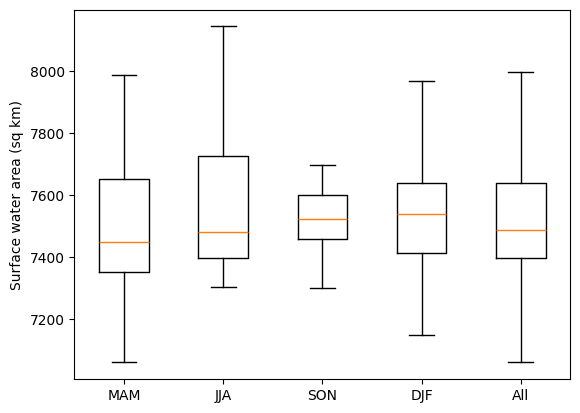

In [ ]:
# Get a list of data values for each season so that we can plot multiple boxplots in one figure
data = [df['area'].values for df in [mam_area, jja_area, son_area, djf_area, allmonths_area]]
fig, ax = plt.subplots()  # Initialize the figure
ax.boxplot(data, showfliers=False)  # Plot the boxplots (one for each season, and the full dataset)
# Make cosmetic adjustments to the plot for clarity
ax.set(adjustable = 'box')
ax.set_xticklabels(["MAM", "JJA", "SON", "DJF", "All"])
ax.set_ylabel("Surface water area (sq km)")

We can also directly compare specific values from each distribution. Let's look at the median surface water area value for each season.

In [ ]:
# Get median values
for df, name in zip(data, ['MAM', 'JJA', 'SON', 'DJF', 'All']):
    print(f"Median {name}: {np.median(df):.0f} sq km")

Median MAM: 7448 sq km
Median JJA: 7481 sq km
Median SON: 7523 sq km
Median DJF: 7539 sq km
Median All: 7489 sq km


> *Reflection questions*:
- Which seasons have the highest and lowest median surface water value? What factors do you think drive that?
- Does it make sense given the climatology of the area?

# 4. Identify trends in surface water area over time

Next, we will check for trends in surface water area over time for each season by fitting a linear regression model to each time series.

Plot time series of surface water values, showing each season in a different color:

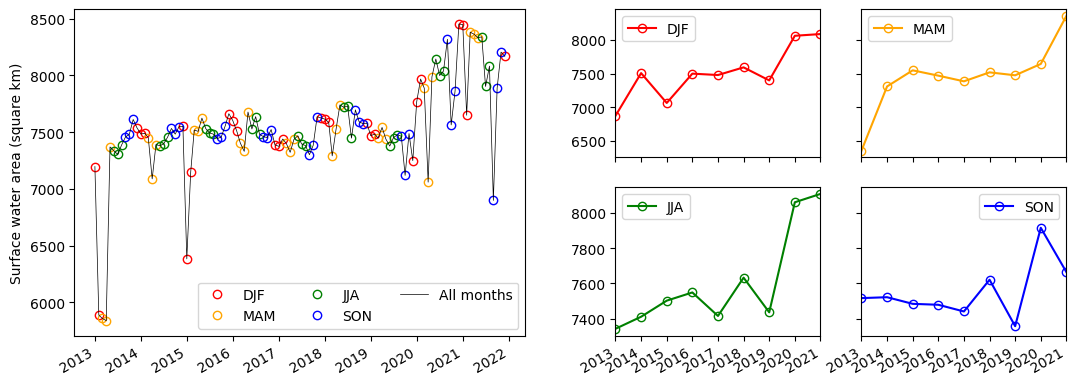

In [ ]:
# This code just sets up the matrix of plots we want
fig = plt.figure(figsize=(2*6.4, 4.8))
gs0 = gridspec.GridSpec(1, 2, figure=fig)
gs00 = gs0[0].subgridspec(1, 1)
ax1 = fig.add_subplot(gs00[0])
gs01 = gs0[1].subgridspec(2, 2)
ax2 = fig.add_subplot(gs01[0, 0])#.set_ylim([6e9])
ax3 = fig.add_subplot(gs01[0, 1], sharey=ax2)
ax4 = fig.add_subplot(gs01[1, 0], sharex=ax2)
ax5 = fig.add_subplot(gs01[1, 1], sharex=ax3, sharey=ax4)

# Plot all seasons together (large plot on the left)
djf_area.rename({'area': 'DJF'}, axis=1).plot(ax=ax1, color = 'red', marker='o', markerfacecolor='None', linestyle='None')
mam_area.rename({'area': 'MAM'}, axis=1).plot(ax=ax1, color = 'orange', marker='o', markerfacecolor='None', linestyle='None')
jja_area.rename({'area': 'JJA'}, axis=1).plot(ax=ax1, color = 'green', marker='o', markerfacecolor='None', linestyle='None')
son_area.rename({'area': 'SON'}, axis=1).plot(ax=ax1, color = 'blue', marker='o', markerfacecolor='None', linestyle='None')
allmonths_area.rename({'area': 'All months'}, axis=1).plot(ax=ax1, ylabel="Surface water area (square km)", color='black', linewidth=0.5)
ax1.legend(ncol=3, loc="lower right")

# Make individual plots for yearly means of each season (2x2 grid of plots on the right)
djf_area.rename({'area': 'DJF'}, axis=1).resample("1y").mean().plot(ax=ax2, color = 'red', marker='o', markerfacecolor='None')
mam_area.rename({'area': 'MAM'}, axis=1).resample("1y").mean().plot(ax=ax3, color = 'orange', marker='o', markerfacecolor='None')
jja_area.rename({'area': 'JJA'}, axis=1).resample("1y").mean().plot(ax=ax4, color = 'green', marker='o', markerfacecolor='None')
son_area.rename({'area': 'SON'}, axis=1).resample("1y").mean().plot(ax=ax5, color = 'blue', marker='o', markerfacecolor='None')

# Make x-axis dates readable
plt.gcf().autofmt_xdate()

For each season, we will use the function `get_trend` to:
1. Fit a linear regression model to the time series
2. Apply the model fit to the time series to get a linear trendline to plot with the real data points

In [ ]:
def get_trend(df):
  """Returns the surface water areas estimated from
  a linear fit to the time series.
  ---
  Params:
      df (pd.DataFrame):
          Surface water area time series
  Returns:
      pd.DataFrame:
          Surface water time series estimated from the linear trend
  """
  # Modify the datetimes to be the number of days since the first data point
  df_mod = df.reset_index().rename({'index': 'x', 'area': 'y'}, axis=1)
  df_mod['x'] = df_mod['x'].astype('datetime64[s]').astype(int).astype(float)
  df_mod['x'] = (df_mod['x'] - df_mod['x'].min())/3600  # days since start
  # Linear regression with scipy
  fit = scipy.stats.linregress(df_mod['x'], df_mod['y'])
  # Apply the linear model
  y_trend = df_mod['x'] * fit.slope + fit.intercept  #
  df_trend = pd.DataFrame(dict(area=y_trend.values), index=df.index)
  return df_trend

# Get linear estimates for each season
df_trend_all = get_trend(allmonths_area)
df_trend_djf = get_trend(djf_area)
df_trend_mam = get_trend(mam_area)
df_trend_jja = get_trend(jja_area)
df_trend_son = get_trend(son_area)

For a sense of the overall trend in surface water area, we can remove seasonality from the time series by subtracting monthly means of surface water area before calculating the linear trend.

In [ ]:
def remove_monthly_mean(df, col):
    """Subtract each month's mean to remove seasonality.
    Add back in the overall mean to get values in the same range as the
    original dataset.
    ---
    Params:
        df (pd.DataFrame)
        col (str): name of column with data values
    Returns:
        pd.DataFrame:
            Same structure as input df but with the monthly means removed
    """
    return pd.DataFrame({col: df[col] - df[col].groupby(df.index.month).transform('mean') + df[col].mean()})

# Remove monthly means and get trend
allmonths_area_rmm = remove_monthly_mean(allmonths_area, 'area')
df_trend_all_rmm = get_trend(allmonths_area_rmm)

Plot the trend lines and their corresponding data points:

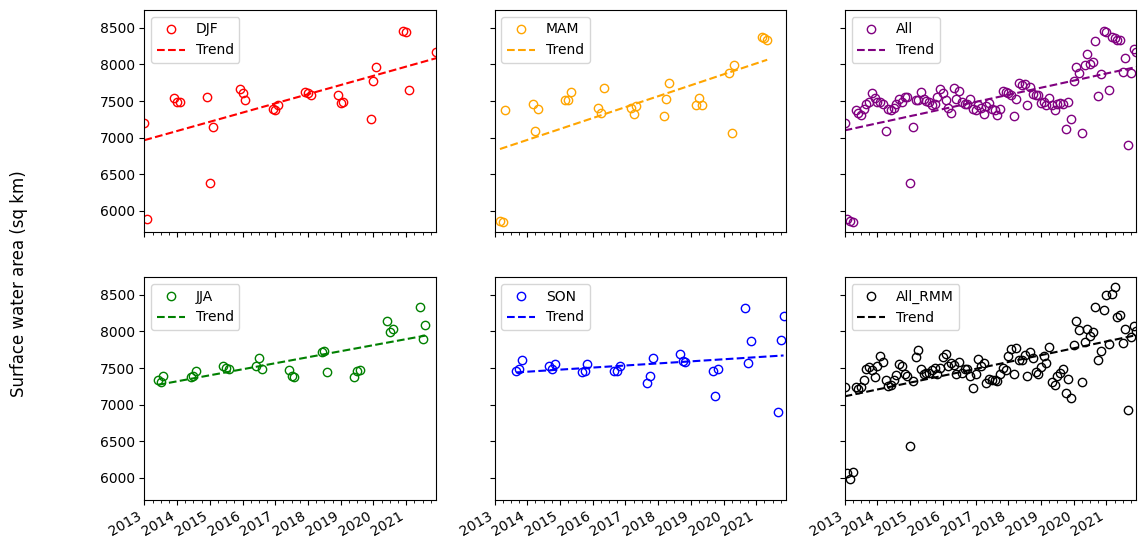

In [ ]:
# Initialize plots
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(6.4*2, 4.8*1.5))
fig.supylabel("Surface water area (sq km)")

# Plot data points
allmonths_area.rename({'area': 'All'}, axis=1).plot(ax=axs[0, 2], color = 'purple', marker='o', markerfacecolor='None', linestyle='None')
djf_area.rename({'area': 'DJF'}, axis=1).plot(ax=axs[0, 0], color = 'red', marker='o', markerfacecolor='None', linestyle='None')
mam_area.rename({'area': 'MAM'}, axis=1).plot(ax=axs[0, 1], color = 'orange', marker='o', markerfacecolor='None', linestyle='None')
jja_area.rename({'area': 'JJA'}, axis=1).plot(ax=axs[1, 0], color = 'green', marker='o', markerfacecolor='None', linestyle='None')
son_area.rename({'area': 'SON'}, axis=1).plot(ax=axs[1, 1], color = 'blue', marker='o', markerfacecolor='None', linestyle='None')

# Plot trend lines
df_trend_all.rename({'area': 'Trend'}, axis=1).plot(ax=axs[0, 2], color='purple', linestyle='--')
df_trend_djf.rename({'area': 'Trend'}, axis=1).plot(ax=axs[0, 0], color='red', linestyle='--')
df_trend_mam.rename({'area': 'Trend'}, axis=1).plot(ax=axs[0, 1], color='orange', linestyle='--')
df_trend_jja.rename({'area': 'Trend'}, axis=1).plot(ax=axs[1, 0], color='green', linestyle='--')
df_trend_son.rename({'area': 'Trend'}, axis=1).plot(ax=axs[1, 1], color='blue', linestyle='--')


# Add plots for all data (and trends) with monthly means removed
allmonths_area_rmm.rename({'area': 'All_RMM'}, axis=1).plot(ax=axs[1, 2], color = 'black', marker='o', markerfacecolor='None', linestyle='None')
df_trend_all_rmm.rename({'area': 'Trend'}, axis=1).plot(ax=axs[1, 2], color='black', linestyle='--')

# Make x-axis dates readable
plt.gcf().autofmt_xdate()

> *Reflection questions*:
- Do you think the trends we found here are significant? Why or why not?
- If so, what factors might have caused them?
- Do you find them surprising?

# Closing remarks
In this tutorial, we used a monthly surface water dataset to identify seasonal patterns and linear trends in surface water area over a nine year period. We emphasize that this kind of analysis is a starting point, not a definitive answer, for characterizing water resources.

We saw that satellite remote sensing data has many limitations to be cautious of, namely:

1. Low data coverage in early satelitte missions,
2. Limitations to spatial coverage depending on the type and orbital path of a satellite,
3. Indirect nature of satellite measurements (they are always derived from raw signals using imperfect models).

While outside the scope of this tutorial, note that the methods commonly used in statistics to test for the significance (and uncertainty) of a result are crucial for drawing reasonable conclusions from remote sensing datasets.